# Recommendation System for Anime Recommendations

In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [3]:
# Lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as m
import sklearn
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict
import torch.nn as nn
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
import ast
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [4]:
print("num of gpu: ", len(tf.config.list_physical_devices('GPU')))
print("devices", tf.config.list_physical_devices())

tf.debugging.set_log_device_placement(False)

num of gpu:  1
devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Preparations

In [5]:
# data
data = pd.read_csv('/kaggle/input/user-animelist-dataset/animes.csv')
ratings = pd.read_csv('/kaggle/input/user-animelist-dataset/ratings.csv')[:70000000]
data.head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
0,1,Howl's Moving Castle,Howl no Ugoku Shiro,MOVIE,2004,8.41,1,https://myanimelist.net/anime/431,False,https://cdn.myanimelist.net/images/anime/1470/...,"['Adventure', 'Award Winning', 'Drama', 'Fanta...","['action', 'adventure', 'age gap', 'air force'..."
1,2,Death Note,NaN,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,TV,2013,7.42,10,https://myanimelist.net/anime/15315,False,https://cdn.myanimelist.net/images/anime/12/43...,"['Action', 'Comedy', 'Fantasy']","['action', 'alternative world', 'anthropomorph..."
3,4,BTOOOM!,Btooom!,TV,2012,7.34,12,https://myanimelist.net/anime/14345,False,https://cdn.myanimelist.net/images/anime/4/409...,"['Action', 'Sci-Fi', 'Suspense']","['achronological order', 'action', 'adventure'..."
4,5,Sword Art Online,NaN,TV,2012,7.5,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'action drama', 'adventure', 'alter..."


In [6]:
ratings.head()

,userID,animeID,rating
0,1,1,10
1,1,2,10
2,1,3,7
3,1,4,10
4,1,5,10


In [7]:
len(ratings)

70000000

In [8]:
#unique ratings -per user
check_1 = ratings[ratings['userID']==1]
check_2 = ratings[ratings['userID']==2]
print(len(check_1)==len(check_2))

False


In [9]:
#score calculations for each animeid =2
p=2
total = sum(ratings[ratings['animeID']==p].rating)
length =len(ratings[ratings['animeID']==p])
print(total/length)

8.415183653643908


In [10]:
# check nan and other vals

print(ratings.isna().sum())
print()
print(data.isna().sum())

userID     0
animeID    0
rating     0
dtype: int64

animeID                  0
title                    0
alternative_title    11561
type                     0
year                     0
score                    0
episodes                 0
mal_url                  0
sequel                   0
image_url                0
genres                   0
genres_detailed          0
dtype: int64


In [11]:
# check dups
print(ratings.duplicated().sum())
print(data.duplicated().sum())

756424
0


In [12]:
print(data.info())
print()
print(data.dtypes)
print()
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20237 entries, 0 to 20236
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   animeID            20237 non-null  int64 
 1   title              20237 non-null  object
 2   alternative_title  8676 non-null   object
 3   type               20237 non-null  object
 4   year               20237 non-null  object
 5   score              20237 non-null  object
 6   episodes           20237 non-null  int64 
 7   mal_url            20237 non-null  object
 8   sequel             20237 non-null  bool  
 9   image_url          20237 non-null  object
 10  genres             20237 non-null  object
 11  genres_detailed    20237 non-null  object
dtypes: bool(1), int64(2), object(9)
memory usage: 1.7+ MB
None

animeID               int64
title                object
alternative_title    object
type                 object
year                 object
score                object


In [13]:
# dropping dups in ratings

ratings.drop_duplicates()

,userID,animeID,rating
0,1,1,10
1,1,2,10
2,1,3,7
3,1,4,10
4,1,5,10
...,...,...,...
69999884,1004773,6302,10
69999885,1004773,8129,10
69999886,1004773,5189,10
69999887,1004773,6044,6


In [14]:
#changing empty titles
data['alternative_title'] = data['alternative_title'].fillna('No other title')
data[data['alternative_title']=='No other title'].head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
1,2,Death Note,No other title,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in..."
4,5,Sword Art Online,No other title,TV,2012,7.5,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'action drama', 'adventure', 'alter..."
7,8,Magi: The Labyrinth of Magic,No other title,TV,2012,8,25,https://myanimelist.net/anime/14513,False,https://cdn.myanimelist.net/images/anime/11/42...,"['Action', 'Adventure', 'Fantasy']","['action', 'adventure', 'against destiny', 'al..."
8,9,Accel World,No other title,TV,2012,7.31,24,https://myanimelist.net/anime/11759,False,https://cdn.myanimelist.net/images/anime/1002/...,"['Action', 'Romance', 'Sci-Fi']","['action', 'alternative world', 'antihero', 'a..."
11,12,Cowboy Bebop,No other title,TV,1998,8.66,26,https://myanimelist.net/anime/1,False,https://cdn.myanimelist.net/images/anime/4/196...,"['Action', 'Award Winning', 'Sci-Fi']","['action', 'adult cast', 'adventure', 'air com..."


In [15]:
# finding '?' values
col = data.columns
df_q = data[data.isin(['?']).any(axis=1)]
df_q

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
7376,7377,Jujutsu Kaisen: Shimetsu Kaiyuu,No other title,TV,?,8.52,1,https://myanimelist.net/anime/57658,True,https://cdn.myanimelist.net/images/anime/1889/...,"['Action', 'Supernatural']","['action', 'angst', 'based on a manga', 'battl..."
8017,8018,Sword Art Online (Original Movie),No other title,MOVIE,?,8.9,1,https://myanimelist.net/anime/53529,False,https://cdn.myanimelist.net/images/anime/1537/...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'adventure', 'based on a light nove..."
8209,8210,Saezuru Tori wa Habatakanai: The Storm Breaks,No other title,MOVIE,?,?,1,https://myanimelist.net/anime/41289,False,https://cdn.myanimelist.net/images/anime/1941/...,"['Boys Love', 'Drama', 'Erotica']","['adult couples', 'based on a manga', 'bl', 'b..."
8434,8435,Omniscient Reader,Zenchi-teki na Dokusha no Shiten kara,TV,?,10,1,https://myanimelist.net/anime/59230,False,https://cdn.myanimelist.net/images/anime/1549/...,"['Action', 'Adventure', 'Fantasy']","['action', 'action drama', 'adventure', 'alter..."
9055,9056,Tensei shitara Slime Datta Ken 4th Season,No other title,TV,?,10,1,https://myanimelist.net/anime/59970,True,https://cdn.myanimelist.net/images/anime/1699/...,"['Action', 'Comedy', 'Fantasy']","['action', 'adventure', 'agender', 'alternativ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
20215,20216,Ikimono-san Pilot,No other title,MOVIE,2022,?,1,https://myanimelist.net/anime/56507,False,https://cdn.myanimelist.net/images/anime/1683/...,"['Avant Garde', 'Comedy']","['avant garde', 'comedy']"
20221,20222,Moshi Juexing: Suyuan,No other title,ONA,2020,?,26,https://myanimelist.net/anime/45447,False,https://cdn.myanimelist.net/images/anime/1486/...,"['Action', 'Sci-Fi']","['action', 'adventure', 'cg animation', 'cg-an..."
20225,20226,Season of Change,Neulin Jangma,ONA,2022,?,10,https://myanimelist.net/anime/56643,False,https://cdn.myanimelist.net/images/anime/1213/...,"['Drama', 'Romance']","['drama', 'romance']"
20233,20234,Merry PLLIstmas,No other title,SPECIAL,2023,?,1,https://myanimelist.net/anime/57643,False,https://cdn.myanimelist.net/images/anime/1205/...,['Fantasy'],"['idol', 'idols (male)', 'music']"


In [16]:
print(f'? in score',len(data[data['score'] == '?']))
print(f'? in year',len(data[data['year'] == '?']))

? in score 593
? in year 136


In [17]:
n_data = data.copy()
n_data = n_data[n_data['year'] != '?']
n_data['year'] = pd.to_numeric(n_data['year'])

def mean(col):
    return(sum(col)/len(col))

print(f'newest content',n_data['year'].max())
print(f'oldest content',n_data['year'].min())
print(f'avg release',int(mean(n_data['year'])))

newest content 2027
oldest content 1907
avg release 2008


In [18]:
l_data = data.copy()
l_data = l_data[l_data['score'] !='?']
l_data['score'] = pd.to_numeric(l_data['score'])

print(f'avg score', mean(l_data['score']))

avg score 6.315589492974932


In [19]:
# change all '?' in years into the avg release
data['year'] = data['year'].replace('?', int(mean(n_data['year'])))
data['score'] = data['score'].replace('?', float(mean(l_data['score'])))
print(f'? in year',len(data[data['year'] == '?']))
print(f'? in score',len(data[data['score'] == '?']))

? in year 0
? in score 0


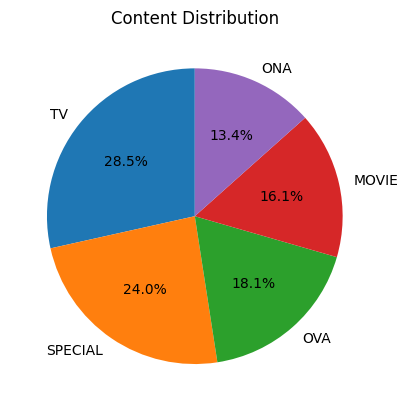

In [20]:
data['type'].nunique()

types_con = data['type'].value_counts()
plt.pie(types_con, labels=types_con.index, autopct='%1.1f%%', startangle=90)
plt.title('Content Distribution')
plt.show()

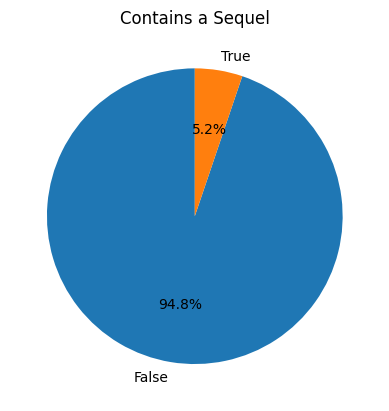

In [21]:
data['sequel'].nunique()

seq_con = data['sequel'].value_counts()
plt.pie(seq_con, labels=seq_con.index, autopct='%1.1f%%', startangle=90)
plt.title('Contains a Sequel')
plt.show()

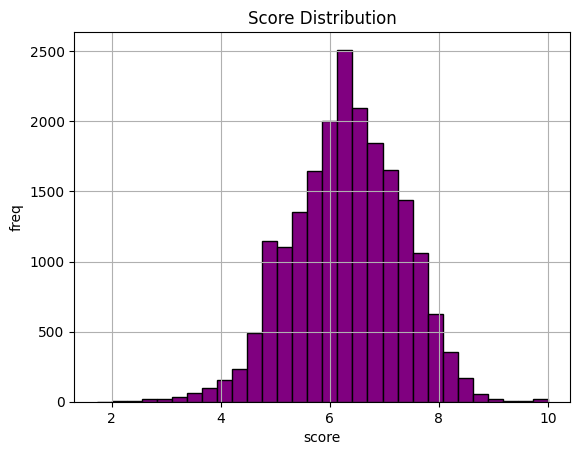

In [22]:
# anime score distribution

dist_score = data['score'].astype(float)
plt.hist(dist_score, bins=30, color='purple', edgecolor='black')
plt.title('Score Distribution')
plt.xlabel('score')
plt.ylabel('freq')
plt.grid(True)
plt.show()

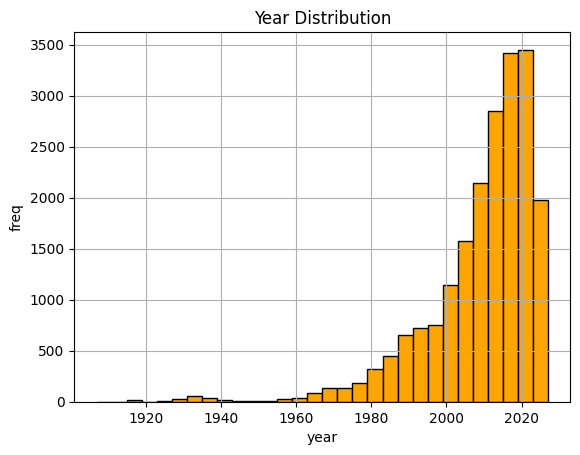

In [23]:
dist_year = data['year'].astype(int)
plt.hist(dist_year, bins=30, color='orange', edgecolor='black')
plt.title('Year Distribution')
plt.xlabel('year')
plt.ylabel('freq')
plt.grid(True)
plt.show()

In [24]:
data.head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
0,1,Howl's Moving Castle,Howl no Ugoku Shiro,MOVIE,2004,8.41,1,https://myanimelist.net/anime/431,False,https://cdn.myanimelist.net/images/anime/1470/...,"['Adventure', 'Award Winning', 'Drama', 'Fanta...","['action', 'adventure', 'age gap', 'air force'..."
1,2,Death Note,No other title,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,TV,2013,7.42,10,https://myanimelist.net/anime/15315,False,https://cdn.myanimelist.net/images/anime/12/43...,"['Action', 'Comedy', 'Fantasy']","['action', 'alternative world', 'anthropomorph..."
3,4,BTOOOM!,Btooom!,TV,2012,7.34,12,https://myanimelist.net/anime/14345,False,https://cdn.myanimelist.net/images/anime/4/409...,"['Action', 'Sci-Fi', 'Suspense']","['achronological order', 'action', 'adventure'..."
4,5,Sword Art Online,No other title,TV,2012,7.5,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'action drama', 'adventure', 'alter..."


In [25]:
#incase u want to use this cleaned dataset for other purposes
data.to_csv('cleaned_animelist.csv')

# Pre-Processing and Model Development

In [26]:
n_ratings = ratings['userID'].value_counts()

# onlt people who rate more than 300 animes will be considered
ratings_df = ratings[ratings['userID'].isin(n_ratings[n_ratings>300].index)]
print(len(ratings_df))
ratings_df.head()

26098231


,userID,animeID,rating
305,5,12,8
306,5,122,8
307,5,62,6
308,5,214,8
309,5,215,8


In [27]:
# normalize the ratings
min_ratings = min(ratings_df['rating'])
max_ratings = max(ratings_df['rating'])

ratings_df['rating'] = (ratings_df['rating'] - min_ratings)/(max_ratings - min_ratings)
ratings_df.head()

/tmp/ipykernel_761/2625483796.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['rating'] = (ratings_df['rating'] - min_ratings)/(max_ratings - min_ratings)


,userID,animeID,rating
305,5,12,0.8
306,5,122,0.8
307,5,62,0.6
308,5,214,0.8
309,5,215,0.8


In [28]:
# create matrix to see each userID to animeID ratings

group = ratings_df.groupby('animeID')['rating'].count()
top_anime = group.sort_values(ascending = False)[:10]
top_r = ratings_df.join(top_anime, rsuffix='_r', on='animeID', how='inner')

group = ratings_df.groupby('userID')['rating'].count()
top_user = group.sort_values(ascending=False)[:10]
top_r = top_r.join(top_user, rsuffix='_r', on='userID', how='inner')

#plot
pd.crosstab(top_r.userID, top_r.animeID, top_r.rating, aggfunc=np.sum)

/tmp/ipykernel_761/316591171.py:12: FutureWarning: The provided callable <function sum at 0x7df31a5ac360> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.userID, top_r.animeID, top_r.rating, aggfunc=np.sum)
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


animeID,2,5,20,86,92,99,100,121,1136,1139
userID,,,,,,,,,,
701416,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0,0.5,0.5
753904,1.0,0.7,0.9,1.0,0.6,1.0,0.9,0.9,0.9,0.6
768674,1.0,0.3,1.0,1.0,1.0,1.0,0.5,0.9,1.0,0.9
778915,0.5,NaN,0.5,0.5,0.9,1.0,0.8,0.5,0.9,1.0
826008,1.0,0.7,0.9,1.0,0.6,1.0,0.9,0.9,0.9,0.6
829685,1.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,1.0
850779,1.0,NaN,1.0,0.7,0.9,1.0,0.7,0.3,0.8,0.5
866455,1.0,0.7,0.9,1.0,0.6,1.0,0.9,1.0,0.9,0.6
947622,1.0,0.7,0.9,1.0,0.6,1.0,0.9,0.9,0.9,0.6


In [29]:
# encode

#get unique ids
anime_ids = ratings_df['animeID'].unique().tolist()
user_ids = ratings_df['userID'].unique().tolist()

#thing --> thing_encoded
user_userEncoded = {x : i for i , x in enumerate(user_ids)}
anime_animeEncoded = {x: i for i, x in enumerate(anime_ids)}

#thing_encoded --> thing
userEncoded_user = {i: x for i, x in enumerate(user_ids)}
animeEncoded_anime = {i:x for i, x in enumerate(anime_ids)}

#map
ratings_df['user'] = ratings_df['userID'].map(user_userEncoded)
ratings_df['anime'] = ratings_df['animeID'].map(anime_animeEncoded)

print(f'amount of users',len(user_userEncoded))
print(f'amount of animes',len(anime_animeEncoded))
print(f'min rating', min(ratings_df['rating']))
print(f'max rating',max(ratings_df['rating']))

/tmp/ipykernel_761/3542944748.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['user'] = ratings_df['userID'].map(user_userEncoded)
/tmp/ipykernel_761/3542944748.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['anime'] = ratings_df['animeID'].map(anime_animeEncoded)


amount of users 51559
amount of animes 16350
min rating 0.0
max rating 1.0


In [30]:
len(ratings_df)

26098231

In [31]:
#shuffle data
ratings_df = ratings_df.sample(frac=1, random_state=42)

x = ratings_df[['user','anime']].values
y = ratings_df['rating']

#split
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=0.1)
print(f'shape x_train',x_train.shape)
print(f'shape x_val',x_val.shape)
print(f'shape y_train',y_train.shape)
print(f'shape y_val',y_val.shape)

shape x_train (23488407, 2)
shape x_val (2609824, 2)
shape y_train (23488407,)
shape y_val (2609824,)


In [32]:
# split x arr from train-val
x_train_arr = [x_train[:,0], x_train[:,1]]
x_val_arr = [x_val[:,0], x_val[:,1]]

n_users = len(user_userEncoded)
n_animes = len(anime_animeEncoded)

# Model Building

In [33]:
# embedding layers
def RecommenderAnime():
    embedding_size=128

    #user
    user = Input(name='user', shape=[1])
    user_embeddings = Embedding(name = 'user_embedding',
                               input_dim = n_users,
                               output_dim = embedding_size)(user)
    #anime
    anime = Input(name='anime', shape=[1])
    anime_embeddings =Embedding(name='anime_embedding',
                               input_dim = n_animes,
                               output_dim = embedding_size)(anime)
    
    #combine (dotproduct of both)
    x = Dot(name='dotProduct', normalize=True, axes=2)([user_embeddings, anime_embeddings])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    #model
    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss = 'binary_crossentropy', metrics = ['mse', 'mae'], optimizer = 'Adam')
    return model


#define model
model =RecommenderAnime()
model.summary()

I0000 00:00:1754028656.954756     761 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │  6,599,552 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,092,800 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dotProduct (Dot)    │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dotProduct[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,692,358 (33.16 MB)

 Trainable params: 8,692,356 (33.16 MB)

 Non-trainable params: 2 (8.00 B)

In [34]:
# early stop-callbacks

#params
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000
ramp_up_epochs = 5
sustain_epochs =0
exp_decay = 0.8

# learning rates
def learning_rate_fn(epoch):
    if epoch< ramp_up_epochs:
        return (max_lr - start_lr)/ramp_up_epochs*epoch + start_lr
    elif epoch < ramp_up_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr)*exp_decay**(epoch-ramp_up_epochs-sustain_epochs)+min_lr

learning_rate_callback = LearningRateScheduler(lambda epoch: learning_rate_fn(epoch), verbose=0)

checkpoint_filepath = './weights.weights.h5'
checkpoint_model = ModelCheckpoint(filepath = checkpoint_filepath,
                                 save_weights_only = True,
                                 monitor= 'val_loss',
                                 mode =min,
                                 save_best_only = True)
early_stop = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

#callbacks_cus
callbacks_sum = [learning_rate_callback,checkpoint_model, early_stop]

/tmp/ipykernel_761/3134701684.py:24: UserWarning: ModelCheckpoint mode '<built-in function min>' is unknown, fallback to auto mode.
  checkpoint_model = ModelCheckpoint(filepath = checkpoint_filepath,


In [35]:
# training
history = model.fit(
    x = x_train_arr,
    y = y_train,
    batch_size = batch_size,
    verbose=1,
    epochs=25,
    validation_data = (x_val_arr, y_val),
    callbacks = callbacks_sum
    
)
model.load_weights(checkpoint_filepath)

Epoch 1/25


I0000 00:00:1754028663.550842     795 service.cc:148] XLA service 0x7def2c009f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1754028663.551692     795 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1754028663.828887     795 cuda_dnn.cc:529] Loaded cuDNN version 90300


  47/2349 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.7975 - mae: 0.2919 - mse: 0.1253  

I0000 00:00:1754028664.609024     795 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2349/2349 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - loss: 0.7948 - mae: 0.2907 - mse: 0.1241 - val_loss: 0.7862 - val_mae: 0.2869 - val_mse: 0.1210 - learning_rate: 1.0000e-05
Epoch 2/25
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7803 - mae: 0.2840 - mse: 0.1186 - val_loss: 0.7675 - val_mae: 0.2780 - val_mse: 0.1139 - learning_rate: 1.8000e-05
Epoch 3/25
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7564 - mae: 0.2723 - mse: 0.1092 - val_loss: 0.7388 - val_mae: 0.2630 - val_mse: 0.1022 - learning_rate: 2.6000e-05
Epoch 4/25
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.7194 - mae: 0.2521 - mse: 0.0939 - val_loss: 0.6820 - val_mae: 0.2292 - val_mse: 0.0778 - learning_rate: 3.4000e-05
Epoch 5/25
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6582 - mae: 0.2139 - mse: 0.0672 - val_loss: 0.6245 - val_mae: 0.1891 - val_mse: 0.0521 - learning_rate: 4.2000e-05
Epoch 6/25
2349/2349 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.6100 - mae: 0.1778 - mse: 0.0454 - val_lo

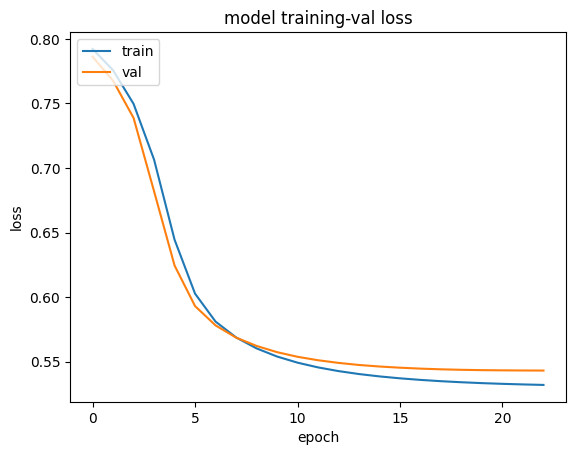

In [36]:
# plot loss
plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model training-val loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [37]:
# save the model - only if u finalize training
model.save_weights("final.weights.h5")

In [189]:
# save the model as a whole - only if u finalize
model.save("recommendation_anime_model.keras")

In [38]:
# save the encoders - only if u finalize trarning
import pickle
with open("user_mapping.pkl", "wb") as f:
    pickle.dump(user_userEncoded, f)
with open("anime_mapping.pkl", "wb") as f:
    pickle.dump(anime_animeEncoded, f)

In [188]:
with open("rev_user_mapping.pkl", "wb") as f:
    pickle.dump(userEncoded_user, f)
with open("rev_anime_mapping.pkl", "wb") as f:
    pickle.dump(animeEncoded_anime, f)

# Extracting Weights

In [39]:
#get the weights for both user and animes

def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights

anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

# Interference Example

In [40]:
# get names from id

def get_anime(anime_id):
    if anime_id in ratings_df['animeID'].values:
        anime = data[data['animeID'] == anime_id]
    else:
        anime = "no anime recorded"
    return anime

In [41]:
get_anime(100)

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
99,100,My Hero Academia,Boku no Hero Academia,TV,2016,8.1,13,https://myanimelist.net/anime/31964,False,https://cdn.myanimelist.net/images/anime/10/78...,['Action'],"['action', 'action comedy', 'adventure', 'aim ..."


In [42]:
#based on id or name str

def getAnimeFrame(anime):
    if isinstance(anime, int):
        return data[data.animeID == anime]
    if isinstance(anime, str):
        return data[data.title == anime]
    else:
        return "not comprehendable"

In [43]:
getAnimeFrame('My Hero Academia')

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
99,100,My Hero Academia,Boku no Hero Academia,TV,2016,8.1,13,https://myanimelist.net/anime/31964,False,https://cdn.myanimelist.net/images/anime/10/78...,['Action'],"['action', 'action comedy', 'adventure', 'aim ..."


In [44]:
def find_similar_animes(name, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name).animeID.values[0]
        encoded_index = anime_animeEncoded.get(index)
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1            
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('animes closest to {}'.format(name))

        if return_dist:
            return dists, closest


        SimilarityArr = []

        for close in closest:
            decoded_id = animeEncoded_anime.get(close)
            anime_frame = getAnimeFrame(decoded_id) 
            anime_name = anime_frame.title.values[0]
            genre = anime_frame.genres.values[0]
            score= anime_frame.score.values[0]
            episodes = anime_frame.episodes.values[0]
            similarity = dists[close]
            
            SimilarityArr.append({"anime_id": decoded_id, "name": anime_name,
                                  "similarity": similarity,"genre": genre,
                                  "episodes":episodes,"score":score
                                  })

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(['anime_id'], axis=1)

    except:
        print('{}!, Not Found in Anime list'.format(name))

In [45]:
#recoms anime from anime
find_similar_animes('Jujutsu Kaisen',n=10)

animes closest to Jujutsu Kaisen


,name,similarity,genre,episodes,score
9,Demon Slayer: Kimetsu no Yaiba Entertainment D...,0.946436,"['Action', 'Supernatural']",11,8.81
8,Demon Slayer: Kimetsu no Yaiba,0.941467,"['Action', 'Award Winning', 'Supernatural']",26,8.57
7,Demon Slayer: Kimetsu no Yaiba - The Movie: Mu...,0.938556,"['Action', 'Supernatural']",1,8.63
6,Jujutsu Kaisen 0,0.937697,"['Action', 'Supernatural']",1,8.47
5,Dr. Stone,0.904997,"['Adventure', 'Comedy', 'Sci-Fi']",24,8.39
4,Jujutsu Kaisen Season 2,0.898651,"['Action', 'Supernatural']",23,8.77
3,Spy x Family,0.883867,"['Action', 'Award Winning', 'Comedy']",12,8.66
2,Demon Slayer: Kimetsu no Yaiba Swordsmith Vill...,0.882226,"['Action', 'Supernatural']",11,8.45
1,Dr. Stone: Stone Wars,0.878133,"['Adventure', 'Comedy', 'Sci-Fi']",11,8.33
0,The Promised Neverland,0.874339,"['Mystery', 'Suspense']",12,8.49


In [91]:
def find_similar_users(item_input, n=10,return_dist=False, neg=False):
    try:
        index = item_input
        encoded_index = user_userEncoded.get(index)
        weights = user_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]

        print('> similar to #{}'.format(item_input))

        if return_dist:
            return dists, closest
        
        rindex = ratings_df
        SimilarityArr = []
        
        for close in closest:
            similarity = dists[close]

            if isinstance(item_input, int):
                decoded_id = userEncoded_user.get(close)
                SimilarityArr.append({"similar_users": decoded_id, 
                                      "similarity": similarity})

        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", 
                                                        ascending=False)
        
        return Frame
    
    except:
        print('{}!, Not Found in User list')

In [47]:
ratings_df[:3]

,userID,animeID,rating,user,anime
15310138,264762,1188,0.9,10424,711
42539446,784427,5685,0.8,28346,5747
13913196,225071,545,0.6,9826,390


In [48]:
# find the similar user
rand_user = '47660'
similar_users = find_similar_users(int(rand_user), 
                                   n=5, 
                                   neg=False)
similar_users = similar_users[similar_users.similarity > 0.4]
similar_users = similar_users[similar_users.similar_users != rand_user]
similar_users[:5]

> users similar to #47660


,similar_users,similarity
5,47660,1.000000
4,767633,0.436133
3,692838,0.425836
2,725082,0.421117
1,908333,0.420927


In [49]:
def getFavGenre(frame):
        frame.dropna(inplace=False)
        all_genres = defaultdict(int)
        
        genre_list = []
        for genre in frame['genre']:
            if isinstance(genre, str):
                for genre in genre.split(','):
                    genre_list.append(genre)
                    all_genre[genre.strip()] += 1    
        
        return genres_list


def get_user_preferences(user_id, verbose=0):
    animes_watched_by_user = ratings_df[ratings_df.userID==int(user_id)]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)
        .animeID.values
    )
    
    anime_df_rows = data[data["animeID"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["title"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')
        
    return anime_df_rows

In [50]:
user_pref = get_user_preferences(rand_user, verbose=0)
print(user_pref)

                                                  title
1                                            Death Note
5                                         Spirited Away
6                                     Princess Mononoke
11                                         Cowboy Bebop
12                                  Fullmetal Alchemist
...                                                 ...
4698                                     Kemono Friends
4835                                  Junkers Come Here
5118                                   Tomorrow's Joe 2
5773  Crayon Shin-chan Movie 09: Arashi wo Yobu Mour...
6931                                      Answer (2016)

[121 rows x 1 columns]


In [51]:
def get_recommended_animes(similar_users, n=10):
    recommended_animes = []
    anime_list = []
    
    for user_id in similar_users.similar_users.values:
        pref_list = get_user_preferences(int(user_id), verbose=0)
        pref_list = pref_list[~ pref_list.title.isin(user_pref.title.values)]
        anime_list.append(pref_list.title.values)
        
    anime_list = pd.DataFrame(anime_list)
    sorted_list = pd.DataFrame(pd.Series(anime_list.values.ravel()).value_counts()).head(n)
    
    for i, anime_name in enumerate(sorted_list.index):        
        n_user_pref = sorted_list.loc[anime_name]

        if isinstance(anime_name, str):
            frame = getAnimeFrame(anime_name)
    
            if not frame.empty:
                try:
                    anime_id = frame['animeID'].values[0]
                    genre = frame['genres'].values[0]
                    score = frame['score'].values[0]
                    episodes = frame['episodes'].values[0]
    
                    recommended_animes.append({ 
                        "anime_name": anime_name, 
                        "genre": genre, 
                        "score": score, 
                        "episodes": episodes
                    })
                except Exception as e:
                    print(f"Error processing '{anime_name}': {e}")
    
    return pd.DataFrame(recommended_animes)

In [52]:
# recoms anime per user
recommended_animes = get_recommended_animes(similar_users, n=10)
recommended_animes

,anime_name,genre,score,episodes
0,The Disappearance of Haruhi Suzumiya,"['Award Winning', 'Mystery', 'Sci-Fi', 'Supern...",8.62,1
1,Kino's Journey,"['Adventure', 'Drama', 'Fantasy']",8.24,13
2,Barakamon,['Slice of Life'],8.28,12
3,Angel's Egg,"['Avant Garde', 'Drama', 'Fantasy']",7.4,1
4,Silver Spoon 2nd Season,['Comedy'],8.27,11
5,Humanity Has Declined,"['Adventure', 'Comedy', 'Fantasy', 'Sci-Fi']",7.7,12
6,Silver Spoon,['Comedy'],8.04,11
7,Daily Lives of High School Boys,['Comedy'],8.11,12
8,Kaiji: Against All Rules,['Suspense'],8.17,26
9,Owarimonogatari,"['Comedy', 'Mystery', 'Supernatural']",8.35,12


In [53]:
ratings_df[:10]

,userID,animeID,rating,user,anime
15310138,264762,1188,0.9,10424,711
42539446,784427,5685,0.8,28346,5747
13913196,225071,545,0.6,9826,390
58424568,911463,3042,0.9,41744,4326
8150509,94208,1033,0.9,6516,785
64659515,962405,5854,0.6,46949,5459
67984741,988792,2744,1.0,49848,1960
7398923,83030,2438,0.8,6095,2287
21679372,453898,2859,0.7,13273,2800
41116173,773377,1744,0.7,27101,1929


In [54]:
def interference(test_user):
    similar_users = find_similar_users(int(test_user), 
                                   n=5, 
                                   neg=False)
    similar_users = similar_users[similar_users.similarity > 0.4]
    similar_users = similar_users[similar_users.similar_users != test_user]
    user_pref = get_user_preferences(test_user, verbose=0)
    recommended_animes = get_recommended_animes(similar_users, n=5)
    return recommended_animes

In [93]:
# combined for a partciluar user

test = '911463'
interference(test)

> similar to #911463


,anime_name,genre,score,episodes
0,Kaguya-sama: Love is War -Ultra Romantic-,"['Comedy', 'Romance']",8.92,13
1,Kaguya-sama: Love is War?,"['Comedy', 'Romance']",8.65,12
2,Angels of Death,"['Adventure', 'Horror', 'Suspense']",7.01,16
3,Kaguya-sama: Love is War,"['Comedy', 'Romance']",8.4,12
4,Assassination Classroom,"['Action', 'Comedy']",8.11,22


In [56]:
animes_watched = ratings_df[ratings_df['userID']==int(test)].animeID
data[data['animeID'].isin(animes_watched)].head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
1,2,Death Note,No other title,TV,2006,8.63,37,https://myanimelist.net/anime/1535,False,https://cdn.myanimelist.net/images/anime/1079/...,"['Supernatural', 'Suspense']","['achronological order', 'acting', 'adapted in..."
2,3,Problem Children Are Coming from Another World...,Mondaiji-tachi ga Isekai kara Kuru Sou desu yo?,TV,2013,7.42,10,https://myanimelist.net/anime/15315,False,https://cdn.myanimelist.net/images/anime/12/43...,"['Action', 'Comedy', 'Fantasy']","['action', 'alternative world', 'anthropomorph..."
4,5,Sword Art Online,No other title,TV,2012,7.5,25,https://myanimelist.net/anime/11757,False,https://cdn.myanimelist.net/images/anime/11/39...,"['Action', 'Adventure', 'Fantasy', 'Romance']","['action', 'action drama', 'adventure', 'alter..."
9,10,Eden of The East,Higashi no Eden,TV,2009,7.81,11,https://myanimelist.net/anime/5630,False,https://cdn.myanimelist.net/images/anime/9/150...,"['Award Winning', 'Mystery', 'Romance', 'Sci-F...","['action', 'adult cast', 'adventure', 'alterna..."
12,13,Fullmetal Alchemist,No other title,TV,2003,8.29,51,https://myanimelist.net/anime/121,False,https://cdn.myanimelist.net/images/anime/10/75...,"['Action', 'Adventure', 'Award Winning', 'Dram...","['action', 'adapted into japanese movie', 'ada..."


# New Users - Outside Ratings_df used in the process above

1. creates a sub embedding for new user
2. finds the nearest user_id which is similar to this new user
3. finds the recommendations of that nearest user

In [96]:
test=pd.read_csv('/kaggle/input/user-animelist-dataset/ratings.csv')[70000000:70005000]

In [97]:
test_user_ids = test['userID'].unique()
test_anime_ids = test['animeID'].unique()

In [140]:
from sklearn.metrics.pairwise import cosine_similarity

def embed_new_user(user_ratings, anime_animeEncoded, anime_weights):
    embeddings = []
    ratings = []
    
    for anime_id, rating in user_ratings:
        encoded = anime_animeEncoded.get(anime_id)
        if encoded is not None:
            embeddings.append(anime_weights[encoded])
            ratings.append(rating)
    
    if embeddings:
        user_emb = np.average(embeddings, axis=0, weights=ratings)
        return user_emb
    else:
        return None

def similar_new_user(new_user_emb, user_weights, userEncoded_user):
    similarities = cosine_similarity([new_user_emb], user_weights)[0]
    most_similar_idx = np.argmax(similarities)
    most_similar_user_id = userEncoded_user[most_similar_idx]
    return most_similar_user_id, similarities[most_similar_idx]

def get_similar_test(user_id):
    test_anime_ratings = test[test['userID']==user_id].drop(['userID'],axis=1).values.tolist()
    new_user_emb = embed_new_user(test_anime_ratings, anime_animeEncoded, anime_weights)

    if new_user_emb is not None:
        most_similar_user_id, similarity_score = similar_new_user(new_user_emb, user_weights, userEncoded_user)
        print(f"Most similar user : {most_similar_user_id}, similar: {similarity_score:.4f}")
    else:
        print("No match at all")

    return most_similar_user_id, similarity_score

In [186]:
close = get_similar_test(test_user_ids[1])
interference(close[0])

Most similar user : 701092, similar: 0.8056
> similar to #701092


,anime_name,genre,score,episodes
0,Fire Force,"['Action', 'Fantasy', 'Sci-Fi']",7.86,24
1,KonoSuba: God's Blessing on This Wonderful World!,"['Adventure', 'Comedy', 'Fantasy']",8.1,10
2,KonoSuba: God's Blessing on This Wonderful Wor...,"['Adventure', 'Comedy', 'Fantasy']",8.26,10
3,Haganai: I don't have many friends,"['Comedy', 'Romance', 'Ecchi']",7.29,12
4,Fate/Zero,"['Action', 'Fantasy']",8.27,13


In [187]:
test_user_info = test[test['userID']==test_user]
data[data['animeID'].isin(test_user_info['animeID'])].head()

,animeID,title,alternative_title,type,year,score,episodes,mal_url,sequel,image_url,genres,genres_detailed
24,25,The Devil is a Part-Timer!,Hataraku Maou-sama!,TV,2013,7.8,13,https://myanimelist.net/anime/15809,False,https://cdn.myanimelist.net/images/anime/3/501...,"['Comedy', 'Supernatural']","['action', 'adults are useless', 'air combat',..."
35,36,Naruto,No other title,TV,2002,8.03,220,https://myanimelist.net/anime/20,False,https://cdn.myanimelist.net/images/anime/1141/...,"['Action', 'Adventure', 'Fantasy']","['action', 'adventure', 'alternative world', '..."
58,59,Naruto Shippuden,Naruto: Shippuuden,TV,2007,8.29,500,https://myanimelist.net/anime/1735,False,https://cdn.myanimelist.net/images/anime/1565/...,"['Action', 'Adventure', 'Fantasy']","['action', 'adventure', 'aliens', 'anachronism..."
92,93,Erased,Boku dake ga Inai Machi,TV,2016,8.38,12,https://myanimelist.net/anime/31043,False,https://cdn.myanimelist.net/images/anime/10/77...,"['Mystery', 'Suspense']","['adapted into japanese movie', 'adapted into ..."
98,99,Fullmetal Alchemist: Brotherhood,No other title,TV,2009,9.09,64,https://myanimelist.net/anime/5114,False,https://cdn.myanimelist.net/images/anime/1208/...,"['Action', 'Adventure', 'Drama', 'Fantasy']","['action', 'adapted into japanese movie', 'ada..."


# Full Interference on this code

In [132]:
#some ids
ratings_df['userID'].head()

15310138    264762
42539446    784427
13913196    225071
58424568    911463
8150509      94208
Name: userID, dtype: int64

In [137]:
test_user_ids[:10]

array([1004773, 1004774, 1004775, 1004776, 1004777, 1004778, 1004779,
       1004780, 1004781, 1004782])

# Use this to check recommendations

In [182]:
user = input(' user ID: ')
user_id = int(user)

if user_id in ratings_df['userID'].values:
    recoms = interference(user_id)
else:
    close, score_close = get_similar_test(user_id)
    recoms = interference(close)

 user ID:  911463


> similar to #911463


In [183]:
recoms # for id inside of ratings_df

,anime_name,genre,score,episodes
0,Kaguya-sama: Love is War,"['Comedy', 'Romance']",8.4,12
1,Tonikawa: Over The Moon For You Season 2,"['Comedy', 'Romance']",7.86,12
2,KonoSuba: God's Blessing on This Wonderful Wor...,"['Adventure', 'Comedy', 'Fantasy']",8.26,10
3,Angels of Death,"['Adventure', 'Horror', 'Suspense']",7.01,16
4,Tomo-chan Is a Girl!,"['Comedy', 'Romance']",7.9,13


In [181]:
recoms # for id outside of ratings_df

,anime_name,genre,score,episodes
0,Fate/stay night [Unlimited Blade Works],"['Action', 'Fantasy']",8.2,12
1,KonoSuba: God's Blessing on This Wonderful Wor...,"['Adventure', 'Comedy', 'Fantasy']",8.26,10
2,Fate/Apocrypha,"['Action', 'Fantasy']",7.27,25
3,Violet Evergarden,['Drama'],8.61,13
4,Fate/Zero Season 2,"['Action', 'Fantasy']",8.48,12


# Save Dataset (If needed)

In [62]:
# save ratings_df for other uses
ratings_df.to_csv('ratings_df.csv')